# Assignment 2

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./05_src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model]() or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [84]:
# Load the libraries as required.
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib
import shap


In [80]:
# Load data
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv('../../05_src/data/fires/forestfires.csv', header = 0, names = columns))
fires_dt.info()

# List of numeric columns to plot
num_cols = ['ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']

# # Plot each numeric feature vs area
# for col in num_cols:
#     plt.figure(figsize=(6, 4))
#     sns.scatterplot(x=fires_dt[col], y=np.log1p(fires_dt['area']))
#     plt.title(f'{col} vs Area')
#     plt.xlabel(col)
#     plt.ylabel('Area')
#     plt.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  area     517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [28]:
# # Plot each numeric feature vs area
# for col in num_cols:
#     plt.figure(figsize=(6, 4))
#     sns.scatterplot(x=np.log1p(fires_dt[col]), y=np.log1p(fires_dt['area']))
#     plt.title(f'{col} vs Area')
#     plt.xlabel(col)
#     plt.ylabel('Area')
#     plt.show()

# Get X and Y

Create the features data frame and target data.

In [81]:
# Creating feature data frame
feature_cols = ['coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']
X = fires_dt[feature_cols]
X

,coord_x,coord_y,month,day,ffmc,dmc,dc,isi,temp,rh,wind,rain
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0


In [82]:
# Creating target data frame
y = fires_dt['area']
y

0       0.00
1       0.00
2       0.00
3       0.00
4       0.00
       ...  
512     6.44
513    54.29
514    11.16
515     0.00
516     0.00
Name: area, Length: 517, dtype: float64

# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [13]:
num_cols = ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']
cat_cols = ['month', 'day']

pipe_num_simple = Pipeline([
    ('standardizer', StandardScaler())
])

pipe_cat = Pipeline([
    ('one_hot_encoding', OneHotEncoder(handle_unknown='ignore'))
])

pre_proc_1 = ColumnTransformer([
    ('numeric_simple', pipe_num_simple, num_cols),
    ('categorical', pipe_cat, cat_cols)
], remainder='passthrough')

pre_proc_1.fit(X)
X_transformed = pre_proc_1.transform(X)
feature_names = pre_proc_1.get_feature_names_out()
min_values = X_transformed.min(axis=0)

# Check for NaN values
print("NaN values:", np.isnan(X_transformed).sum())

# Check for infinite values
print("Inf values:", np.isinf(X_transformed).sum())

# Check for nulls (shouldn't be any after transformation, but for completeness)
print("Null values:", pd.isnull(X_transformed).sum().sum())

for name, min_val in zip(feature_names, min_values):
    print(f"{name}: {min_val}")


# 
# feature_names = pre_proc_1.get_feature_names_out()
# print(feature_names)
# print(X.isnull().sum())
# print(np.isinf(X).sum())
# print(y.isnull().sum())
# print(np.isinf(y).sum())

NaN values: 0
Inf values: 0
Null values: 0
numeric_simple__coord_x: -1.5873604423101833
numeric_simple__coord_y: -1.871723911057094
numeric_simple__ffmc: -13.045817904306904
numeric_simple__dmc: -1.715608002630985
numeric_simple__dc: -2.1791082303065763
numeric_simple__isi: -1.9805782080979109
numeric_simple__temp: -2.8769433397170627
numeric_simple__rh: -1.7966369069638166
numeric_simple__wind: -2.0210978828202473
numeric_simple__rain: -0.07326830956410954
categorical__month_apr: 0.0
categorical__month_aug: 0.0
categorical__month_dec: 0.0
categorical__month_feb: 0.0
categorical__month_jan: 0.0
categorical__month_jul: 0.0
categorical__month_jun: 0.0
categorical__month_mar: 0.0
categorical__month_may: 0.0
categorical__month_nov: 0.0
categorical__month_oct: 0.0
categorical__month_sep: 0.0
categorical__day_fri: 0.0
categorical__day_mon: 0.0
categorical__day_sat: 0.0
categorical__day_sun: 0.0
categorical__day_thu: 0.0
categorical__day_tue: 0.0
categorical__day_wed: 0.0


### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [12]:
num_cols = ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']
log_cols = ['ffmc', 'dmc', 'dc', 'isi', 'temp']
non_log_cols = [col for col in num_cols if col not in log_cols]
cat_cols = ['month', 'day']

pipe_non_linear = Pipeline([
    ('log', FunctionTransformer(np.log1p)),
    ('standardizer', StandardScaler())
])

pipe_num_simple = Pipeline([
    ('standardizer', StandardScaler())
])

pipe_cat = Pipeline([
    ('one_hot_encoding', OneHotEncoder(handle_unknown='ignore'))
])

pre_proc_2 = ColumnTransformer([
    ('non_linear', pipe_non_linear, log_cols),
    ('numeric_simple', pipe_num_simple, non_log_cols),
    ('categorical', pipe_cat, cat_cols)
], remainder='passthrough')

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [34]:
# Pipeline A = preproc1 + baseline
pipeline_a = Pipeline([
    ('preprocessing', pre_proc_1),
    ('regressor', LinearRegression())
])
pipeline_a

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric_simple',
                                                  Pipeline(steps=[('standardizer',
                                                                   StandardScaler())]),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('categorical',
                                                  Pipeline(steps=[('one_hot_encoding',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['month', 'day'])])),
                ('regressor', LinearRegression())])

In [35]:
# Pipeline B = preproc2 + baseline
pipeline_b = Pipeline([
    ('preprocessing', pre_proc_2),
    ('regressor', LinearRegression())
])
pipeline_b

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('non_linear',
                                                  Pipeline(steps=[('log',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                  ('standardizer',
                                                                   StandardScaler())]),
                                                  ['ffmc', 'dmc', 'dc', 'isi',
                                                   'temp']),
                                                 ('numeric_simple',
                                                  Pipeline(steps=[('standardizer',
                                                                   StandardScaler())]),
                                                  ['coord_x', 'coord_y', 'rh',
                                                   'wind', 'rain']),
                                                 ('categorical',
                                                  Pipeline(steps=[('one_hot_encoding',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['month', 'day'])])),
                ('regressor', LinearRegression())])

In [36]:
# Pipeline C = preproc1 + advanced model
pipeline_c = Pipeline([
    ('preprocessing', pre_proc_1),
    ('regressor', RandomForestRegressor(random_state=42))
])
pipeline_c

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric_simple',
                                                  Pipeline(steps=[('standardizer',
                                                                   StandardScaler())]),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('categorical',
                                                  Pipeline(steps=[('one_hot_encoding',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['month', 'day'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [37]:
# Pipeline D = preproc2 + advanced model
pipeline_d = Pipeline([
    ('preprocessing', pre_proc_2),
    ('regressor', RandomForestRegressor(random_state=42))
])
pipeline_d

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('non_linear',
                                                  Pipeline(steps=[('log',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                  ('standardizer',
                                                                   StandardScaler())]),
                                                  ['ffmc', 'dmc', 'dc', 'isi',
                                                   'temp']),
                                                 ('numeric_simple',
                                                  Pipeline(steps=[('standardizer',
                                                                   StandardScaler())]),
                                                  ['coord_x', 'coord_y', 'rh',
                                                   'wind', 'rain']),
                                                 ('categorical',
                                                  Pipeline(steps=[('one_hot_encoding',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['month', 'day'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [30]:
param_grid_a = {
    'regressor__fit_intercept': [True, False],
}

grid_search_a = GridSearchCV(
    pipeline_a,
    param_grid_a,
    cv=5,
    scoring='neg_root_mean_squared_error',
    error_score='raise'
)

grid_search_a.fit(X, y)
print("Best parameters:", grid_search_a.best_params_)
print("Best RMSE:", -grid_search_a.best_score_)

Best parameters: {'regressor__fit_intercept': True}
Best RMSE: 54.64840128809867


In [31]:
param_grid_b = {
    'regressor__fit_intercept': [True, False],
}

grid_search_b = GridSearchCV(
    pipeline_b,
    param_grid_b,
    cv=5,
    scoring='neg_root_mean_squared_error',
    error_score='raise'
)

grid_search_b.fit(X, y)
print("Best parameters:", grid_search_b.best_params_)
print("Best RMSE:", -grid_search_b.best_score_)

Best parameters: {'regressor__fit_intercept': True}
Best RMSE: 54.46940079006542


In [32]:
param_grid_c = {
    'regressor__n_estimators': [50, 100, 150],
    'regressor__max_depth': [None, 1, 2, 3, 5, 8, 10, 15]
}

grid_search_c = GridSearchCV(
    pipeline_c,
    param_grid_c,
    cv=5,
    scoring='neg_root_mean_squared_error',
    error_score='raise'
)

grid_search_c.fit(X, y)
print("Best parameters:", grid_search_c.best_params_)
print("Best RMSE:", -grid_search_c.best_score_)

Best parameters: {'regressor__max_depth': 1, 'regressor__n_estimators': 50}
Best RMSE: 48.91411622281971


In [33]:
param_grid_d = {
    'regressor__n_estimators': [50, 100, 150],
    'regressor__max_depth': [None, 1, 2, 3, 5, 8, 10, 15]
}

grid_search_d = GridSearchCV(
    pipeline_d,
    param_grid_d,
    cv=5,
    scoring='neg_root_mean_squared_error',
    error_score='raise'
)

grid_search_d.fit(X, y)
print("Best parameters:", grid_search_d.best_params_)
print("Best RMSE:", -grid_search_d.best_score_)

Best parameters: {'regressor__max_depth': 1, 'regressor__n_estimators': 50}
Best RMSE: 48.97985979826283


# Evaluate

+ Which model has the best performance?

As of now, the pipeline C, which is a RandomForestRegressor, with the following hyper params:

{'regressor__max_depth': 1, 'regressor__n_estimators': 50}

The model is pretty bad anyway, with a best RMSE of 48.91411622281971

# Export

+ Save the best performing model to a pickle file.

In [39]:
best_model = grid_search_c.best_estimator_
joblib.dump(best_model, 'best_model_pipeline_c.pkl')

['best_model_pipeline_c.pkl']

# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

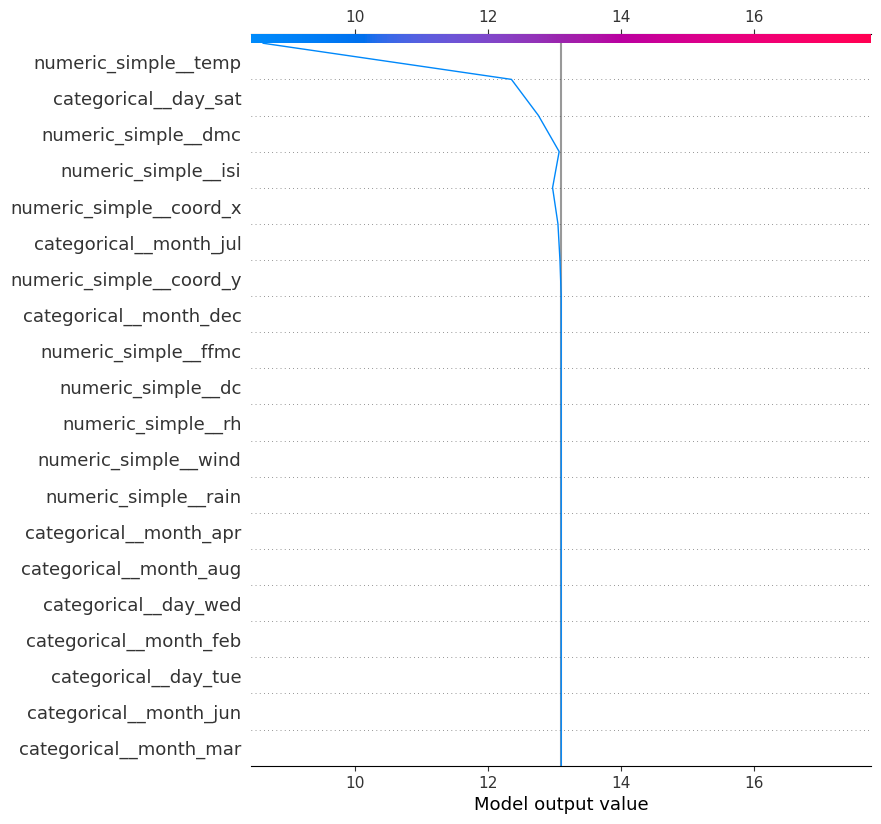

In [ ]:
np.bool = np.bool_
np.str = np.str_
np.object = np.object_

# Use the best model and the same preprocessing as in your pipeline
best_model = grid_search_c.best_estimator_

# Transform your data using the pipeline's preprocessing step
X_transformed = best_model.named_steps['preprocessing'].transform(X)

# Create a SHAP explainer for the RandomForestRegressor
explainer = shap.TreeExplainer(best_model.named_steps['regressor'])

# Calculate SHAP values
shap_values = explainer.shap_values(X_transformed)
shap.initjs()
# shap.force_plot(
#     explainer.expected_value,
#     shap_values[0],
#     feature_names=best_model.named_steps['preprocessing'].get_feature_names_out()
# )
shap.decision_plot(
    explainer.expected_value,
    shap_values[0],  # or shap_values[sample_index] for another sample
    feature_names=list(best_model.named_steps['preprocessing'].get_feature_names_out())
)

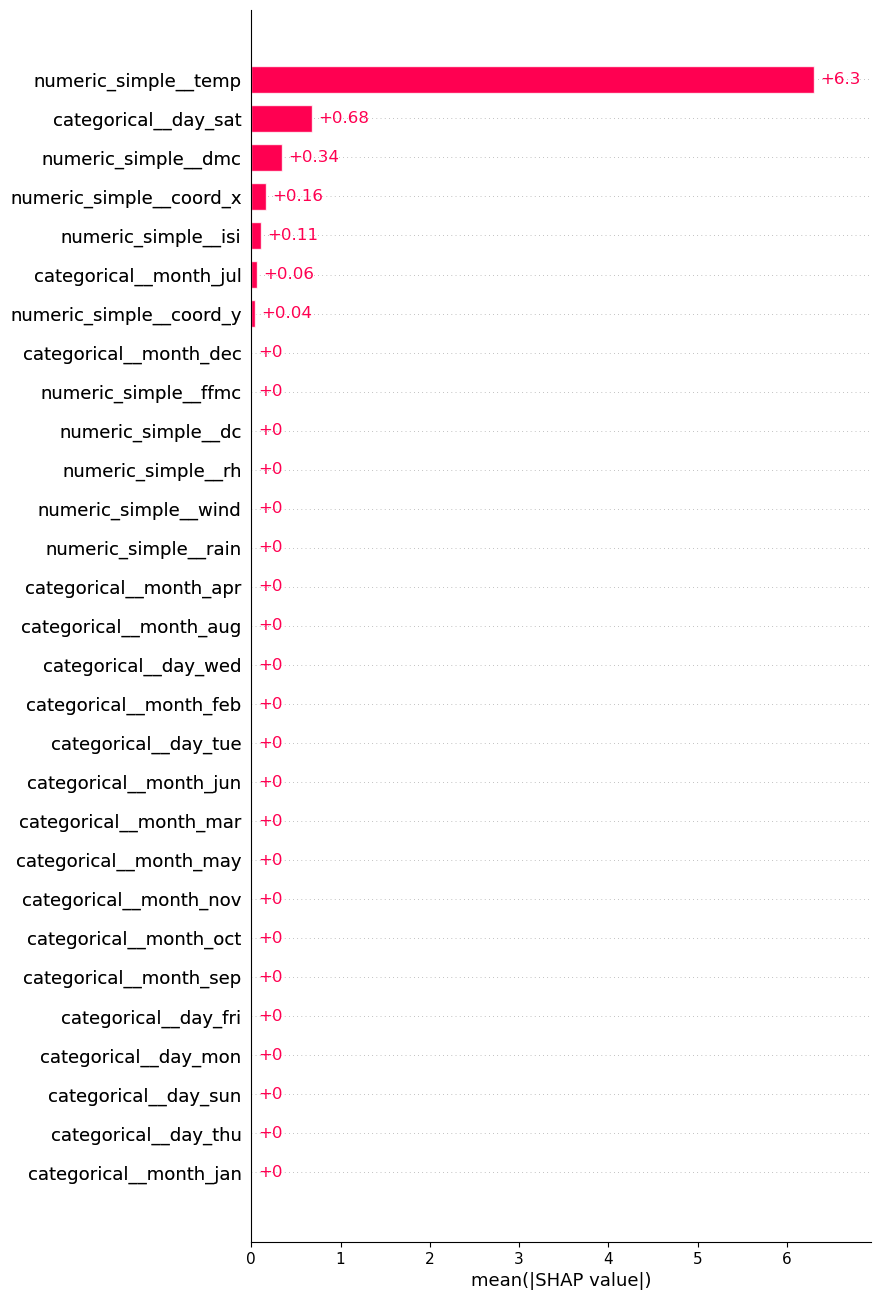

In [ ]:
# shap.summary_plot(
#     shap_values,
#     X_transformed,
#     feature_names=list(best_model.named_steps['preprocessing'].get_feature_names_out()),
#     plot_size=(10, 6)
# )

# import matplotlib.pyplot as plt

# fig, ax = plt.subplots(figsize=(10, 6))
# shap.summary_plot(
#     shap_values,
#     X_transformed,
#     feature_names=list(best_model.named_steps['preprocessing'].get_feature_names_out()),
#     plot_size=None,
#     show=False
# )
# plt.sca(ax)
# plt.show()

# Custom SHAP Beeswarm-like plot using seaborn
# feature_names = list(best_model.named_steps['preprocessing'].get_feature_names_out())
# shap_df = pd.DataFrame(shap_values, columns=feature_names)

# # Melt the DataFrame for seaborn
# shap_long = shap_df.melt(var_name='feature', value_name='shap_value')

# plt.figure(figsize=(10, 8))
# sns.violinplot(
#     data=shap_long,
#     y='feature',
#     x='shap_value',
#     scale='width',
#     inner='quartile',
#     orient='h',
#     order=shap_long.groupby('feature')['shap_value'].apply(lambda x: np.abs(x).mean()).sort_values(ascending=False).index
# )
# plt.title('Custom SHAP Beeswarm-like Plot')
# plt.xlabel('SHAP value')
# plt.ylabel('Feature')
# plt.tight_layout()
# plt.show()

feature_names = list(best_model.named_steps['preprocessing'].get_feature_names_out())

shap.plots.bar(
    shap.Explanation(
        values=shap_values,
        base_values=explainer.expected_value,
        data=X_transformed,
        feature_names=feature_names
    ),
    max_display=len(feature_names),
    show=True
)

Starting with the SHAP graph for an individual prediction, it shows that the most important features that impacted the model prediction are:
- temperature
- saturday (at a glance, this doesn't make sense)
- isi
- dmc
- july

Across the whole predictions, the most importante features were (as per the shap graph):
- temperature
- saturday
- dmc
- coord x
- isi
- july
- coord y

As for which features I would remove, I don't think it makes sense to include days of the week for this kind of predictions (like the column saturday influencing the model), instead focusing on just months which have overall relations to seasons makes more sense.

Other feature I would remove would be many categorical days (like saturday), plus all numeric features that didn't help for the prediction (like wind for example).

Last but not least, I didn't take the time to find strong correlation between the features, if I recall correctly from class, it makes sense to remove features which share strong correlation in the same direction, as in to avoid skewing the results, e.g. ISI is a combination of FFMC and wind, so it makes sense to maybe just keep ISI instead of the other 2 columns.

## Criteria

The [rubric](./assignment_2_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at the `help` channel. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.